In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## First a tutorial making MDS plots with the iris dataset

In [2]:
# https://towardsdatascience.com/visualize-multidimensional-datasets-with-mds-64d7b4c16eaa
# load in the data
data = load_iris()
X = data.data

In [3]:
# 0-1 scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# apply MDS to get a two-dimensional dataset
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X_scaled)

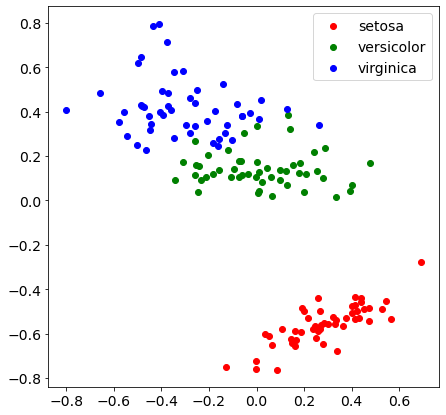

In [5]:
# plot the data
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
for i in np.unique(data.target):
  subset = X_2d[data.target == i]
  
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  plt.scatter(x,y,c=colors[i],label=data.target_names[i])
plt.legend()
plt.show()

## Running MDS with our test data

In [6]:
test = pd.read_csv('result_table.csv')
test.head()

,Sample,SampleName,AT1G22630,AT1G22620,AT1G22610,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,DRX007662,Arabidopsis WT-Col mRNA_seq,37.66,28.68,0.0,--,Col-0,wild type,--,PRJDB2180,30664389,0.8615,4/2/2014
1,DRX007663,Arabidopsis ibm1-4 mRNA_seq,35.22,30.74,0.0,--,Col-0,ibm1-4,--,PRJDB2180,38551905,0.9114,4/2/2014
2,DRX007664,Arabidopsis ibm2-2 mRNA_seq,33.39,28.81,0.0,--,Col-0,ibm2-2,--,PRJDB2180,37223057,0.8343,4/2/2014
3,DRX014481,Y1,8.22,21.83,0.0,root,--,wild type,--,PRJDB1593,95012910,0.8982,2/5/2016
4,DRX014482,Y2,8.53,26.05,0.0,root,--,wild type,--,PRJDB1593,163269003,0.9293,2/5/2016


In [7]:
# keep rows with only certain tissue types for now - this will change with the clean dataset
test = test[(test == 'leaves').any(axis=1)|(test == 'root').any(axis=1)|(test == 'whole plant').any(axis=1)|(test == 'seedlings').any(axis=1)|(test == 'rosette leaf').any(axis=1)]
test['Tissue'].unique()

array(['root', 'whole plant', 'seedlings', 'leaves', 'rosette leaf'],
      dtype=object)

In [8]:
# taking a random 20% sample of the data to see if it speeds up processing time
# also making a variable with the tissue column names to merge back in with the MDS dataframe later on
test_tissue_20 = test.sample(frac=0.2, replace=False, random_state=1)
sample_names = test_tissue_20["Tissue"]
test_tissue_20.shape
#test_tissue_20.to_csv('data_subset.csv')

(2964, 13)

In [9]:
# transform data to contain only genes as columns and tissue types as rows
# first, a dataframe with just tissue types for testing - this will definitely change w/ the entire data set
test_tissue = test_tissue_20[['AT1G22630','AT1G22620','AT1G22610','Tissue']]
test_tissue = test_tissue.set_index('Tissue')
test_tissue = test_tissue.rename_axis('').rename_axis('Gene', axis='columns')
test_tissue.head()
test_tissue.shape

(2964, 3)

In [10]:
# Log transform data - do we need to do this? will the data cleaning group do any transformations?
for c in [c for c in test_tissue.columns if np.issubdtype(test_tissue[c].dtype , np.number)]:
    test_tissue[c] += 1
for c in [c for c in test_tissue.columns if np.issubdtype(test_tissue[c].dtype , np.number)]:
    test_tissue[c] = np.log(test_tissue[c])
test_tissue.head()

Gene,AT1G22630,AT1G22620,AT1G22610
,,,
seedlings,0.000000,0.000000,0.0
rosette leaf,4.137404,3.420673,0.0
seedlings,3.003700,3.628333,0.0
leaves,4.569128,3.209229,0.0
root,0.000000,2.814810,0.0


In [11]:
# apply MDS to get a two-dimensional dataset
mds = MDS(n_components=2, random_state=3)
test_mds = mds.fit_transform(test_tissue)

In [12]:
# make dataframe with MDS values
real_mds_df = pd.DataFrame(data = test_mds, columns = ["MDS1", "MDS2"])
real_mds_df.shape

(2964, 2)

In [13]:
# check that tissue column is good
sample_names.head()
sample_names.shape

(2964,)

In [14]:
# add tissue names back in
real_mds_df.reset_index(drop=True, inplace=True)
sample_names.reset_index(drop=True, inplace=True)
final_real_df = pd.concat([sample_names, real_mds_df], axis = 1)
final_real_df.head()

,Tissue,MDS1,MDS2
0,seedlings,2.988634,3.593121
1,rosette leaf,-0.245533,-0.763257
2,seedlings,-0.206622,0.380678
3,leaves,-0.135179,-1.217801
4,root,0.955910,3.228670


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


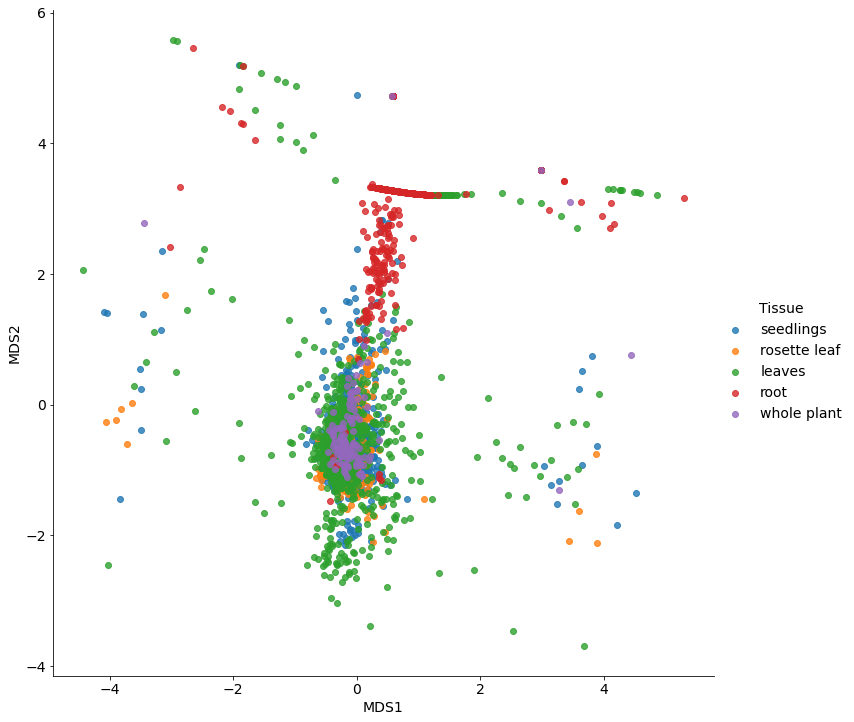

In [15]:
# plot
sns.lmplot('MDS1', 'MDS2', height=10, data=final_real_df, hue="Tissue", fit_reg=False)
#plt.savefig('plot.png')